In [23]:
import os
import torch
import tqdm
import math
import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, \
    LMCVariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt
import pandas as pd
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix,data_transform
import numpy as np
import pickle

smoke_test = ('CI' in os.environ)
%matplotlib inline

In [24]:
from matplotlib import pyplot as plt
import pandas as pd
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix,data_transform
import numpy as np

data = pd.read_csv('../data/tourism_task2_to_r.csv')

data['t'] = data['Date'].astype('datetime64[ns]')
dates_ = data['t'].astype('datetime64[ns]')
data = data.drop('Date', axis=1)

data_pivot = data.pivot(index='t',columns=['state', 'zone', 'region', 'purpose'], values='Count')

groups_input = {
    'state': [0],
    'zone': [1],
    'region': [2],
    'purpose': [3]
}

groups = generate_groups_data_flat(y = data_pivot, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

groups = generate_groups_data_matrix(groups)

dt = data_transform(groups)
groups = dt.std_transf_train()

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [25]:
train_x = torch.arange(groups['train']['n'])
train_x = train_x.type(torch.DoubleTensor)

In [26]:
train_x = train_x.unsqueeze(-1)

In [27]:
train_y = torch.from_numpy(groups['train']['data'])

In [28]:
idxs = []
for k, val in groups['train']['groups_idx'].items():
    idxs.append(val)

# build the matrix

#     Group1     |   Group2
# GP1, GP2, GP3  | GP1, GP2
# 0  , 1  , 1    | 0  , 1  
# 1  , 0  , 0    | 1  , 0  
# 0  , 1, , 1    | 0  , 1 
# 1  , 0  , 1    | 1  , 0  
 

idxs_t = np.array(idxs).T

n_groups = np.sum(np.fromiter(groups['train']['groups_n'].values(), dtype='int32'))
known_mixtures = np.zeros((groups['train']['s'], n_groups))
k=0
for j in range(groups['train']['g_number']):
    for i in range(np.max(idxs_t[:,j])+1):
        idx_to_1 = np.where(idxs_t[:,j]==i)
        known_mixtures[:,k][idx_to_1] = 1
        k+=1

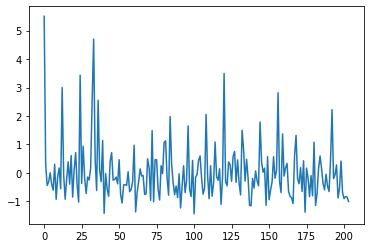

In [29]:
plt.plot(train_y[:,0]);

In [30]:
groups['h']

24

In [31]:
covs = []
for i in range(1, n_groups+1):
    # RBF kernel
    rbf_kernel = gpytorch.kernels.RBFKernel()
    rbf_kernel.lengthscale = torch.tensor([1.])
    scale_rbf_kernel = gpytorch.kernels.ScaleKernel(rbf_kernel)
    scale_rbf_kernel.outputscale=torch.tensor([0.5])
    
    # Periodic Kernel
    periodic_kernel = gpytorch.kernels.PeriodicKernel()
    periodic_kernel.period_length = torch.tensor([12])
    periodic_kernel.lengthscale=torch.tensor([0.5])
    scale_periodic_kernel = gpytorch.kernels.ScaleKernel(periodic_kernel)
    scale_periodic_kernel.outputscale=torch.tensor([1.5])
    
    # Cov Matrix
    cov = scale_rbf_kernel + scale_periodic_kernel
    covs.append(cov)

# apply mixtures to covariances
selected_covs = []
mixed_covs = []
for i in range(groups['train']['s']):
    mixture_weights = known_mixtures[i]
    for w_ix in range(n_groups):
        w = mixture_weights[w_ix]
        if w == 1.0:
            selected_covs.append(covs[w_ix])
    mixed_cov = selected_covs[0]
    for cov in range(1,len(selected_covs)):
        mixed_cov += selected_covs[cov] # because GP(cov1 + cov2) = GP(cov1) + GP(cov2)
    mixed_covs.append(mixed_cov) 
    selected_covs = [] # clear out cov list

In [32]:
mixed_covs

[AdditiveKernel(
   (kernels): ModuleList(
     (0): ScaleKernel(
       (base_kernel): RBFKernel(
         (raw_lengthscale_constraint): Positive()
       )
       (raw_outputscale_constraint): Positive()
     )
     (1): ScaleKernel(
       (base_kernel): PeriodicKernel(
         (raw_lengthscale_constraint): Positive()
         (raw_period_length_constraint): Positive()
       )
       (raw_outputscale_constraint): Positive()
     )
     (2): ScaleKernel(
       (base_kernel): RBFKernel(
         (raw_lengthscale_constraint): Positive()
       )
       (raw_outputscale_constraint): Positive()
     )
     (3): ScaleKernel(
       (base_kernel): PeriodicKernel(
         (raw_lengthscale_constraint): Positive()
         (raw_period_length_constraint): Positive()
       )
       (raw_outputscale_constraint): Positive()
     )
     (4): ScaleKernel(
       (base_kernel): RBFKernel(
         (raw_lengthscale_constraint): Positive()
       )
       (raw_outputscale_constraint): Positive()


In [33]:
class LinearMean(gpytorch.means.Mean):
    def __init__(self, input_size, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        if bias:
            self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        else:
            self.bias = None

    def forward(self, x):
        x = x.float()
        res = x.matmul(self.weights).squeeze(-1)
        if self.bias is not None:
            res = res + self.bias
        
        return res

In [34]:
class PiecewiseLinearMean(gpytorch.means.Mean):
    def __init__(self, input_size, changepoints, batch_shape=torch.Size()):
        super().__init__()
        self.changepoints = changepoints
        self.register_parameter(name="k", 
                                parameter=torch.nn.Parameter(torch.tensor([[0.1]])))
        self.register_parameter(name="m", 
                        parameter=torch.nn.Parameter(torch.tensor([[0.1]])))
        self.register_parameter(name="b", 
                        parameter=torch.nn.Parameter(torch.tile(torch.tensor([0.1]), (len(changepoints),))))

    def forward(self, x):
        x = x.float()
        A = (0.5 * (1.0 + torch.sgn(torch.tile(x.reshape((-1,1)), (1,4)) - self.changepoints))).float()
        
        res = ((self.k + torch.matmul(A, self.b.reshape((-1,1))))*x 
               + (self.m + torch.matmul(A, (-torch.from_numpy(changepoints).float() * self.b))).reshape(-1,1))

        return res.reshape((-1,))

In [35]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, cov, changepoints):
        super().__init__(train_x, train_y, likelihood)
        self.changepoints = changepoints
        self.mean_module = PiecewiseLinearMean(train_x.size(-1), self.changepoints)
        self.covar_module = cov
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

n_changepoints = 4
changepoints = np.linspace(0, groups['train']['n'], n_changepoints+2)[1:-1]

model_list = []
likelihood_list = []
for i in range(groups['train']['s']):
    likelihood_list.append(gpytorch.likelihoods.GaussianLikelihood())
    model_list.append(ExactGPModel(train_x, train_y[:,i], likelihood_list[i], mixed_covs[i], changepoints))

    
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [36]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

In [37]:
model

IndependentModelList(
  (models): ModuleList(
    (0): ExactGPModel(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): PiecewiseLinearMean()
      (covar_module): AdditiveKernel(
        (kernels): ModuleList(
          (0): ScaleKernel(
            (base_kernel): RBFKernel(
              (raw_lengthscale_constraint): Positive()
            )
            (raw_outputscale_constraint): Positive()
          )
          (1): ScaleKernel(
            (base_kernel): PeriodicKernel(
              (raw_lengthscale_constraint): Positive()
              (raw_period_length_constraint): Positive()
            )
            (raw_outputscale_constraint): Positive()
          )
          (2): ScaleKernel(
            (base_kernel): RBFKernel(
              (raw_lengthscale_constraint): Positive()
            )
            (raw_outputscale_constraint): Positive()
          )

In [38]:
# this is for running the notebook in our testing framework

training_iterations = 500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Includes GaussianLikelihood parameters

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: 31.020
Iter 2/500 - Loss: 30.397
Iter 3/500 - Loss: 29.782
Iter 4/500 - Loss: 29.174
Iter 5/500 - Loss: 28.575
Iter 6/500 - Loss: 27.983
Iter 7/500 - Loss: 27.399
Iter 8/500 - Loss: 26.824
Iter 9/500 - Loss: 26.257
Iter 10/500 - Loss: 25.698
Iter 11/500 - Loss: 25.147
Iter 12/500 - Loss: 24.605
Iter 13/500 - Loss: 24.071
Iter 14/500 - Loss: 23.546
Iter 15/500 - Loss: 23.029
Iter 16/500 - Loss: 22.520
Iter 17/500 - Loss: 22.020
Iter 18/500 - Loss: 21.529
Iter 19/500 - Loss: 21.046
Iter 20/500 - Loss: 20.571
Iter 21/500 - Loss: 20.105
Iter 22/500 - Loss: 19.647
Iter 23/500 - Loss: 19.198
Iter 24/500 - Loss: 18.757
Iter 25/500 - Loss: 18.324
Iter 26/500 - Loss: 17.900
Iter 27/500 - Loss: 17.484
Iter 28/500 - Loss: 17.076
Iter 29/500 - Loss: 16.676
Iter 30/500 - Loss: 16.284
Iter 31/500 - Loss: 15.900
Iter 32/500 - Loss: 15.524
Iter 33/500 - Loss: 15.155
Iter 34/500 - Loss: 14.795
Iter 35/500 - Loss: 14.442
Iter 36/500 - Loss: 14.097
Iter 37/500 - Loss: 13.759
Iter 38/50

Iter 307/500 - Loss: 1.633
Iter 308/500 - Loss: 1.633
Iter 309/500 - Loss: 1.633
Iter 310/500 - Loss: 1.633
Iter 311/500 - Loss: 1.633
Iter 312/500 - Loss: 1.633
Iter 313/500 - Loss: 1.633
Iter 314/500 - Loss: 1.633
Iter 315/500 - Loss: 1.633
Iter 316/500 - Loss: 1.633
Iter 317/500 - Loss: 1.633
Iter 318/500 - Loss: 1.633
Iter 319/500 - Loss: 1.633
Iter 320/500 - Loss: 1.633
Iter 321/500 - Loss: 1.633
Iter 322/500 - Loss: 1.633
Iter 323/500 - Loss: 1.633
Iter 324/500 - Loss: 1.633
Iter 325/500 - Loss: 1.633
Iter 326/500 - Loss: 1.633
Iter 327/500 - Loss: 1.633
Iter 328/500 - Loss: 1.633
Iter 329/500 - Loss: 1.633
Iter 330/500 - Loss: 1.633
Iter 331/500 - Loss: 1.633
Iter 332/500 - Loss: 1.633
Iter 333/500 - Loss: 1.633
Iter 334/500 - Loss: 1.633
Iter 335/500 - Loss: 1.633
Iter 336/500 - Loss: 1.633
Iter 337/500 - Loss: 1.633
Iter 338/500 - Loss: 1.633
Iter 339/500 - Loss: 1.633
Iter 340/500 - Loss: 1.633
Iter 341/500 - Loss: 1.633
Iter 342/500 - Loss: 1.633
Iter 343/500 - Loss: 1.633
I

In [39]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.arange(groups['predict']['n']).type(torch.DoubleTensor)
    # This contains predictions for both outcomes as a list
    #predictions = likelihood(*model(test_x, test_x))
    predictions = likelihood(*model(*[test_x for i in range(groups['predict']['s'])]))

In [40]:
i = 0
mean = np.zeros((1, groups['predict']['n'], groups['predict']['s']))
lower = np.zeros((1, groups['predict']['n'], groups['predict']['s']))
upper = np.zeros((1, groups['predict']['n'], groups['predict']['s']))
for pred in predictions:
    mean[:,:,i] = pred.mean
    lower[:,:,i], upper[:,:,i] = pred.confidence_region()
    i+=1

mean = ((mean*dt.std_data) + dt.mu_data)
lower = ((lower*dt.std_data) + dt.mu_data)
upper = ((upper*dt.std_data) + dt.mu_data)
groups = dt.inv_transf_train()

pred = groups['predict']['data'].reshape((groups['predict']['s'], -1)).T

In [317]:
# Clip predictions to 0 if there are negative numbers

mean[mean<0] = 0
lower[lower<0] = 0
upper[upper<0] = 0

In [318]:
dataset = 'tourism'

In [319]:
res = calculate_metrics(mean, groups)
metrics_to_table(res)
#with open(f'results_gp_cov_{dataset}.pickle', 'wb') as handle:
#    pickle.dump(res, handle, pickle.HIGHEST_PROTOCOL)

In [612]:
def benchmark_r_mint(groups, dataset):
    h = groups['h']
    
    import unittest

    tc = unittest.TestCase()
    results_r = pd.read_csv(f'./results_{dataset}_hts.csv', delimiter=';')
    
    group_names = list(results_r.columns[:-3])
    group_names.sort()
    for i in group_names:
        results_r = results_r[results_r[i]!='<aggregated>']
    
    new_res_r = results_r

    data_unique = new_res_r['YearMonth'].unique()

    new_res_r['YearMonth'] = new_res_r['YearMonth'].replace(data_unique, np.arange(h))

    new_res_r['concat'] = np.array(list(map(''.join, zip(*[new_res_r[i] for i in group_names]))))

    new_res_r = new_res_r.drop(['.model'], axis=1)
    new_res_r = new_res_r.drop(group_names, axis=1)
    
    group_names_lower = [i.lower() for i in group_names]

    concat = np.array(list(map(''.join, zip(*[groups['train']['groups_names'][i][groups['train']['groups_idx'][i]] for i in group_names_lower]))))

    new_res_r.concat = new_res_r.concat.astype("category")
    new_res_r.concat.cat.set_categories(concat, inplace=True)

    new_res_r = new_res_r.sort_values(["concat", "YearMonth"]).reset_index().drop(['index'], axis=1)

    r_res = new_res_r['.mean'].to_numpy().reshape(groups['train']['s'], h).T
    
    n = groups['train']['n']
    seas = groups['seasonality']
    s = groups['train']['s']

    new_r_all = np.concatenate((pred[:n, :], r_res), axis=0)

    # testing order
    np.testing.assert_array_equal(np.array(list(new_res_r['concat'].unique())), concat)

    # testing result for the most aggregate level
    tc.assertEqual(mase(n,seas,h,np.sum(pred, axis=1).reshape(-1,1),np.sum(new_r_all[n:n+h,:], axis=1).reshape(-1,1)), mase(n,seas,h,np.sum(pred, axis=1).reshape(-1,1),np.sum(new_r_all[n:n+h,:], axis=1).reshape(-1,1)),1.367678386704409)

    # Benchmark R
    res = calculate_metrics(new_r_all.reshape(1, n+h, s), groups)
    metrics_to_table(res)
    
benchmark_r_mint(groups, dataset)

/home/mach2ne/anaconda3/envs/gpytorch/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


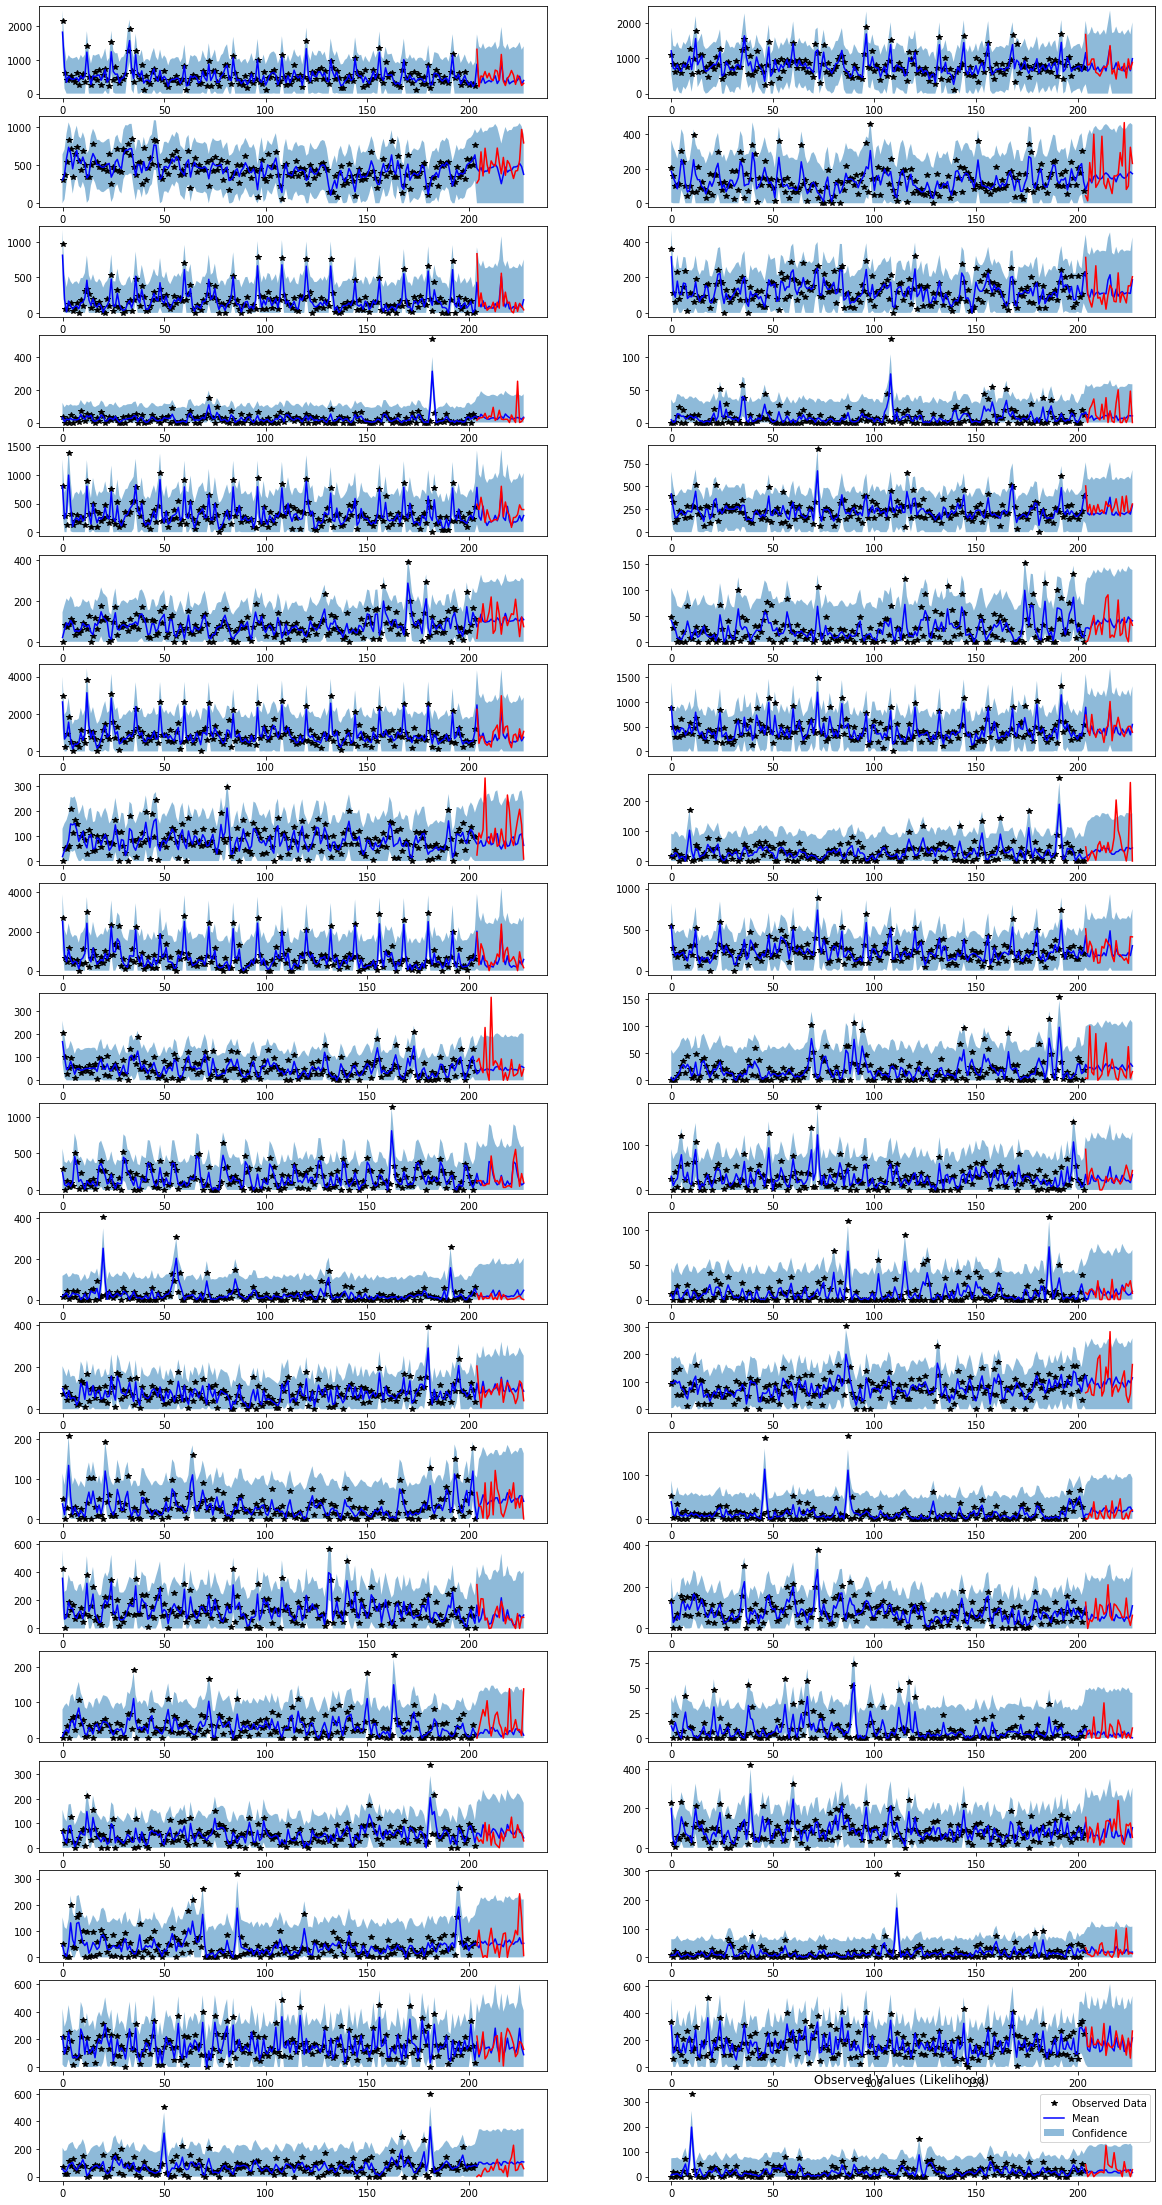

In [320]:
# Initialize plots
f, ax = plt.subplots(20, 2, figsize=(20, 40))
ax = ax.ravel()
for i in range(40):
    # Plot training data as black stars
    ax[i].plot(train_x, groups['train']['data'][:,i], 'k*')
    # Predictive mean as blue line
    ax[i].plot(test_x.numpy(), mean[0,:,i], 'b')
    # Shade in confidence
    ax[i].fill_between(test_x.numpy(), lower[0,:,i], upper[0,:,i], alpha=0.5)
    ax[i].plot(test_x[groups['train']['n']:].numpy(), pred[groups['train']['n']:,i], 'r')
    
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title('Observed Values (Likelihood)')

None

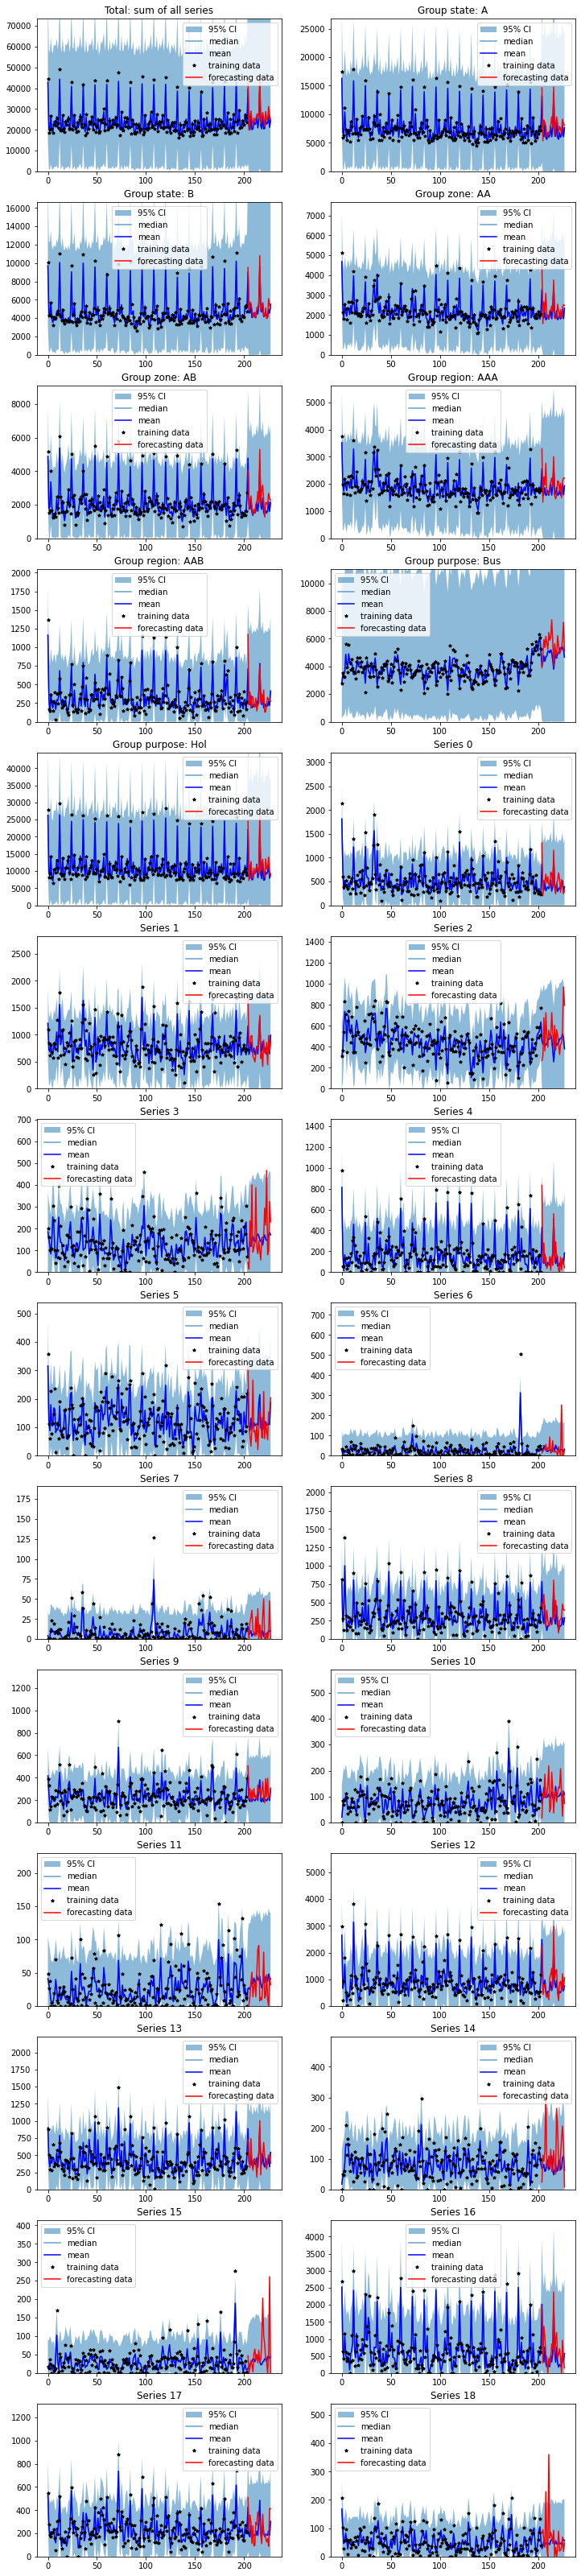

In [321]:
visualize_predict(groups, mean, lower, upper, 20)

In [174]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

models.0.likelihood.noise_covar.raw_noise tensor([0.0019])
models.0.mean_module.k tensor([[-0.0016]])
models.0.mean_module.m tensor([[0.0075]])
models.0.mean_module.b tensor([-0.0005,  0.0005, -0.0004, -0.0020])
models.0.covar_module.kernels.0.raw_outputscale tensor(-0.3800)
models.0.covar_module.kernels.0.base_kernel.raw_lengthscale tensor([[0.6087]])
models.0.covar_module.kernels.1.raw_outputscale tensor(1.2721)
models.0.covar_module.kernels.1.base_kernel.raw_lengthscale tensor([[-0.3450]])
models.0.covar_module.kernels.1.base_kernel.raw_period_length tensor([[12.0002]])
models.0.covar_module.kernels.2.raw_outputscale tensor(-0.3804)
models.0.covar_module.kernels.2.base_kernel.raw_lengthscale tensor([[0.6105]])
models.0.covar_module.kernels.3.raw_outputscale tensor(1.2756)
models.0.covar_module.kernels.3.base_kernel.raw_lengthscale tensor([[-0.3621]])
models.0.covar_module.kernels.3.base_kernel.raw_period_length tensor([[11.9971]])
models.0.covar_module.kernels.4.raw_outputscale tens

models.127.mean_module.k tensor([[-0.0003]])
models.127.mean_module.m tensor([[-0.0007]])
models.127.mean_module.b tensor([7.5544e-05, 4.2079e-04, 6.7703e-05, 1.0690e-03])
models.128.likelihood.noise_covar.raw_noise tensor([0.0571])
models.128.mean_module.k tensor([[0.0014]])
models.128.mean_module.m tensor([[-0.0079]])
models.128.mean_module.b tensor([ 1.3416e-03, -1.2361e-05, -1.7305e-03, -1.9583e-03])
models.128.covar_module.kernels.4.raw_outputscale tensor(-0.3793)
models.128.covar_module.kernels.4.base_kernel.raw_lengthscale tensor([[0.6060]])
models.128.covar_module.kernels.5.raw_outputscale tensor(1.2585)
models.128.covar_module.kernels.5.base_kernel.raw_lengthscale tensor([[-0.2911]])
models.128.covar_module.kernels.5.base_kernel.raw_period_length tensor([[11.9970]])
models.129.likelihood.noise_covar.raw_noise tensor([0.0323])
models.129.mean_module.k tensor([[-0.0016]])
models.129.mean_module.m tensor([[0.0046]])
models.129.mean_module.b tensor([-0.0011,  0.0008,  0.0025,  0.0

models.252.covar_module.kernels.4.base_kernel.raw_lengthscale tensor([[0.6086]])
models.252.covar_module.kernels.5.raw_outputscale tensor(1.2681)
models.252.covar_module.kernels.5.base_kernel.raw_lengthscale tensor([[-0.3328]])
models.252.covar_module.kernels.5.base_kernel.raw_period_length tensor([[12.0054]])
models.253.likelihood.noise_covar.raw_noise tensor([0.0492])
models.253.mean_module.k tensor([[8.0679e-05]])
models.253.mean_module.m tensor([[0.0050]])
models.253.mean_module.b tensor([-1.1272e-03, -1.5337e-03, -4.1150e-05,  1.5184e-03])
models.254.likelihood.noise_covar.raw_noise tensor([0.0539])
models.254.mean_module.k tensor([[-0.0018]])
models.254.mean_module.m tensor([[0.0073]])
models.254.mean_module.b tensor([-0.0015, -0.0004,  0.0020,  0.0123])
models.255.likelihood.noise_covar.raw_noise tensor([0.0343])
models.255.mean_module.k tensor([[0.0014]])
models.255.mean_module.m tensor([[-0.0048]])
models.255.mean_module.b tensor([ 0.0009, -0.0004, -0.0028, -0.0018])
models.25

In [45]:
import numpy as np
import tabulate
from sklearn.metrics import mean_squared_error
from IPython.display import HTML, display
import pandas as pd


def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


def calculate_metrics(pred_samples,
                      groups):

    pred_s0 = pred_samples.shape[0]
    pred_s1 = pred_samples.shape[1]
    pred_s2 = pred_samples.shape[2]

    pred_samples = pred_samples.reshape(pred_s0, pred_s1*pred_s2, order='F')

    seasonality = groups['seasonality']
    h = groups['h']
    
    n = groups['predict']['n']
    s = groups['predict']['s']
    y_f = groups['predict']['data'].reshape(s, n).T

    y_all_g = {}
    f_all_g = {}
    
    mase_ = {}
    rmse_ = {}
    
    # Bottom
    y_all_g['bottom'] = y_f
    f_all_g['bottom'] = np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]
    
    mase_['bottom'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_f, 
                                     f=np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:]),3)
    rmse_['bottom'] = np.round(mean_squared_error(y_f[n-h:n,:], np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], squared=False), 3)

    # Total
    y_all_g['total'] = np.sum(y_f, axis=1).reshape(-1,1)
    f_all_g['total'] = np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1)
    
    mase_['total'] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=np.sum(y_f, axis=1).reshape(-1,1), 
                                     f=np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:], axis=1).reshape(-1,1))
                            ,3)
    rmse_['total'] = np.round(mean_squared_error(np.sum(y_f, axis=1).reshape(-1,1)[n-h:n,:], 
                                             np.sum(np.mean(pred_samples, axis=0).reshape(s, n).T[n-h:n,:],axis=1).reshape(-1,1), 
                                             squared=False), 3)

    # Groups
    idx_dict_new = {}
    for group in list(groups['predict']['groups_names'].keys()):
        y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
        f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

        for idx, name in enumerate(groups['predict']['groups_names'][group]):               

            g_n = groups['predict']['groups_n'][group]

            idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

            y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
            f_g[:,idx] = np.sum(idx_dict_new[name]*np.mean(pred_samples, axis=0).reshape(s, n).T, axis=1)[n-h:n]

        y_all_g[group] = np.sum(y_g, axis=1).reshape(-1,1)
        f_all_g[group] = np.sum(f_g, axis=1).reshape(-1,1)

        mase_[group] = np.round(mase(n=n-h, 
                                     seas=seasonality, 
                                     h=h, 
                                     y=y_g, 
                                     f=f_g)
                                ,3)

        rmse_[group] = np.round(mean_squared_error(y_g[n-h:n,:], f_g, squared=False), 3)

    # All
    y_all = np.concatenate([y_all_g[x] for x in y_all_g], 1)
    f_all = np.concatenate([f_all_g[x] for x in f_all_g], 1)

    mase_['all'] = np.round(mase(n=n-h, 
                         seas=seasonality, 
                         h=h, 
                         y=y_all, 
                         f=f_all),3)
    rmse_['all'] = np.round(mean_squared_error(y_all[n-h:n,:], f_all, squared=False), 3)
    
    results = {}
    results['mase'] = mase_
    results['rmse'] = rmse_
    return results


def metrics_to_table(metrics):
    metrics_l = []
    metrics_v = []
    for metric_name in metrics:
        metrics_list=[]
        metrics_values=[]
        metrics_list.append('')
        metrics_values.append(metric_name)
        for key, metric in metrics[metric_name].items():
            metrics_list.append(key)
            metrics_values.append(metric)
        metrics_v.append(metrics_values)
    metrics_l.append(metrics_list)
    metrics_l.extend(metrics_v)
    table = metrics_l
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [46]:
def visualize_predict(groups, pred_samples_predict, lower, upper, n_bottom_series_to_show, levels=[0,1,2]):
    """
    Parameters
    ----------
    levels: list
                0 -> total, 1 -> groups, 2 -> bottom
                Default to [0,1,2]
    """
    n_series_to_show = n_bottom_series_to_show
    if 0 in levels:
        n_series_to_show += 1 
    if 1 in levels:
        for _,k in groups['predict']['groups_n'].items():
            n_series_to_show += 2 # only show two series of each group aggregate
            
    fig, ax = plt.subplots(int(n_series_to_show/2), 2, figsize=(12,n_series_to_show*2))
    ax = np.ravel(ax)
    n = groups['train']['n']
    n_new = groups['predict']['n']
    j = 0
    if 0 in levels:
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        y_all_g = np.sum(y_f, axis=1).reshape(-1,1)

        ax[j].fill_between(np.arange(n_new), 
                        np.sum(lower[0,:,:], axis=1),
                        np.sum(upper[0,:,:], axis=1),
                        label='95% CI', alpha=0.5)
        ax[j].plot(np.arange(n_new), 
                np.median(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='tab:blue', alpha=0.7, label='median')
        ax[j].plot(np.arange(n_new), 
                np.mean(np.sum(pred_samples_predict, axis=2).T, axis=1),
                color='b', label='mean')
        ax[j].set_ylim(0,max(np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)*1.5))
        ax[j].plot(np.sum(groups['train']['full_data'], axis=1), 
                'k*',markersize=4, label='training data')
        ax[j].plot(np.arange(n, n_new),
                np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)[n:],
                color='r', label='forecasting data')
        ax[j].legend()
        ax[j].set_title('Total: sum of all series')
        j+=1
    if 1 in levels:
        idx_dict_new = {}
        y_all_g = {}
        f_all_g = {}
        lower_all_g = {}
        upper_all_g = {}
        y_f = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T
        for id_group, group in enumerate(list(groups['predict']['groups_names'].keys())):
            y_g = np.zeros((groups['predict']['n'], 1))
            f_g = np.zeros((groups['predict']['groups_names'][group].shape[0]))

            y_all_g[group] = {}
            f_all_g[group] = {}
            
            lower_all_g[group] = {}
            upper_all_g[group] = {}

            for idx, name in enumerate(groups['predict']['groups_names'][group]):               
                # Only show 2 plots of each group -> change this is to show more
                if idx < 2:
                    g_n = groups['predict']['groups_n'][group]

                    idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)

                    y_g = np.sum(idx_dict_new[name].reshape(1,-1)*y_f, axis=1)
                    f_g = np.sum(idx_dict_new[name].reshape(1,-1)*pred_samples_predict, axis=(2))
                    
                    lower_g = np.sum(idx_dict_new[name].reshape(1,-1)*lower, axis=(2))
                    upper_g = np.sum(idx_dict_new[name].reshape(1,-1)*upper, axis=(2))

                    y_all_g[group][name] = y_g
                    f_all_g[group][name] = f_g
                    lower_all_g[group][name] = lower_g
                    upper_all_g[group][name] = upper_g

                    ax[j].fill_between(np.arange(groups['predict']['n']), 
                                    lower_all_g[group][name][0],
                                    upper_all_g[group][name][0],
                                    label='95% CI', alpha=0.5)
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.median(f_all_g[group][name], axis=0),
                            color='tab:blue', alpha=0.7, label='median')
                    ax[j].plot(np.arange(groups['predict']['n']), 
                            np.mean(f_all_g[group][name], axis=0),
                            color='b', label='mean')
                    ax[j].set_ylim(0,max(y_all_g[group][name])*1.5)
                    ax[j].plot(y_all_g[group][name][:groups['train']['n']], 
                            'k*', markersize=4, label='training data')
                    ax[j].plot(np.arange(groups['train']['n'], groups['predict']['n']),
                            y_all_g[group][name][groups['train']['n']:],
                            color='r', label='forecasting data')
                    ax[j].legend()
                    ax[j].set_title(f'Group {group}: {name}')

                    j+=1
    if 2 in levels:
        for i in range(n_bottom_series_to_show-1):
            ax[j].fill_between(np.arange(n_new), 
                            lower[0,:,i],
                            upper[0,:,i],
                        label='95% CI', alpha=0.5)
            ax[j].plot(np.arange(n_new), np.median(pred_samples_predict[:,:,i], axis=0), color='tab:blue', alpha=0.7, label='median')
            ax[j].plot(np.arange(n_new), np.mean(pred_samples_predict[:,:,i], axis=0), color='b', label='mean')
            ax[j].set_ylim(0,max(groups['predict']['data'][i*n_new:i*n_new+n_new])*1.5)
            ax[j].plot(groups['train']['full_data'][:,i], 'k*', markersize=4, label='training data')
            ax[j].plot(np.arange(n, n_new), groups['predict']['data'][i*n_new+n:i*n_new+n_new], color='r', label='forecasting data')
            ax[j].legend()
            ax[j].set_title(f'Series {i}',)
            j+=1
